Coupling map:


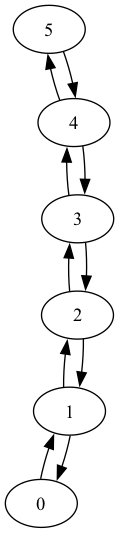

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

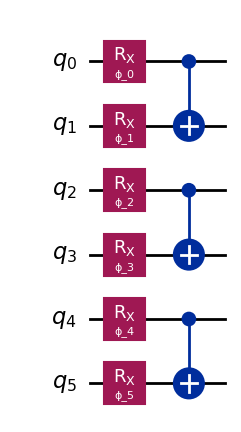

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


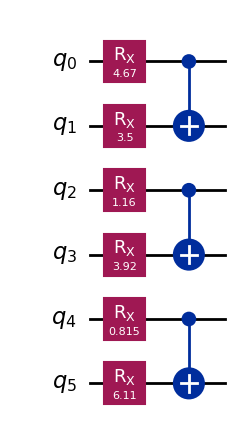

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


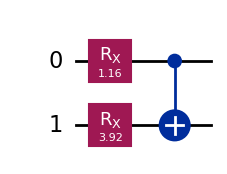

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

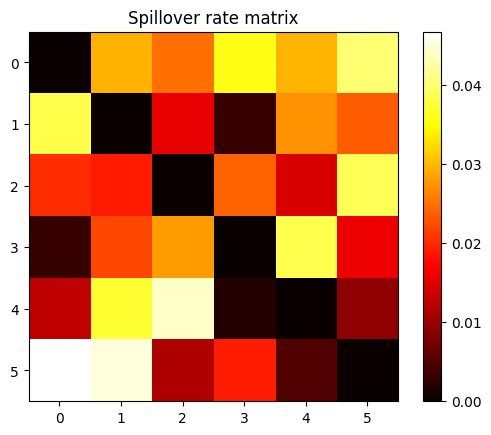

In [33]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
# gamma_matrix[0, 2] = 0.025  # γ_0->1
# gamma_matrix[1, 2] = 0.025  # γ_1->2
# gamma_matrix[3, 2] = 0.025 # γ_3->2
# gamma_matrix[4, 2] = 0.025  # γ_4->2
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 3] = 0.025  # γ_1->3
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
# gamma_matrix[4, 2] = 0.025  # γ_4->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix[5, 3] = 0.025  # γ_5->3
gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)
gamma_matrix[np.arange(num_qubits).astype(np.int8),np.arange(num_qubits).astype(np.int8)] = 0
# gamma_matrix = 0.05 * np.eye(num_qubits)

# Defining spillover matrix
# gamma_matrix = np.diag(np.ones(num_qubits - 1), k=1) * 0.025
# gamma_matrix += np.diag(np.ones(num_qubits - 1), k=-1) * 0.025
# gamma_matrix += np.diag(np.ones(num_qubits - 2), k=-2) * 0.01
# gamma_matrix += np.diag(np.ones(num_qubits - 2), k=2) * 0.01

# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [34]:
gamma_matrix

array([[0.     , 0.0295 , 0.02495, 0.0358 , 0.0297 , 0.04   ],
       [0.03815, 0.     , 0.0156 , 0.00325, 0.02735, 0.02345],
       [0.02015, 0.0188 , 0.     , 0.02395, 0.01455, 0.03885],
       [0.00325, 0.02195, 0.02805, 0.     , 0.0384 , 0.016  ],
       [0.0127 , 0.0372 , 0.0441 , 0.0017 , 0.     , 0.0094 ],
       [0.0467 , 0.045  , 0.0116 , 0.0191 , 0.005  , 0.     ]])

In [35]:
pass_ = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
pass_.spillover_rate_matrix

array([[0.     , 0.0295 , 0.02495, 0.0358 , 0.0297 , 0.04   ],
       [0.03815, 0.     , 0.0156 , 0.00325, 0.02735, 0.02345],
       [0.02015, 0.0188 , 0.     , 0.02395, 0.01455, 0.03885],
       [0.00325, 0.02195, 0.02805, 0.     , 0.0384 , 0.016  ],
       [0.0127 , 0.0372 , 0.0441 , 0.0017 , 0.     , 0.0094 ],
       [0.0467 , 0.045  , 0.0116 , 0.0191 , 0.005  , 0.     ]])

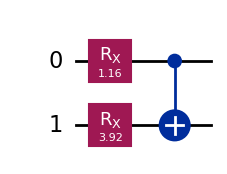

In [36]:
pm = PassManager([pass_])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy.draw("mpl")

In [37]:
print(qc_noisy[0].params)
print(qc_noisy[1].params)

[1.1607433119572852]
[3.9246618340416872]


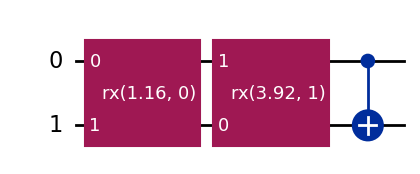

In [38]:
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [39]:
print(qc_noisy[0].params)
print(qc_noisy[1].params)

[array([[0.83625892+0.j        , 0.        -0.54833478j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.54833478j, 0.83625892+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.83625892+0.j        , 0.        -0.54833478j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        -0.54833478j, 0.83625892+0.j        ]])]
[array([[-0.38160732+0.j        ,  0.        -0.92432454j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.92432454j, -0.38160732+0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        -0.92432454j, -0.38160732+0.j        ]])]


In [40]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        -0.54833478j, 0.83625892+0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.83625892+0.j        , 0.        -0.54833478j],
       [0.        +0.j        , 0.        +0.j        ,
        0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=2, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        -0.92432454j, -0.38160732+0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,

In [41]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [42]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': 'fcbac60babbf4428b0ce105e9ff31576',
   'operations': ['rx(1.16, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.98125597+0.j        , 0.        -0.19270891j,
               0.        +0.j        , 0.        +0.j        ],
              [0.        -0.19270891j, 0.98125597+0.j        ,
               0.        +0.j        , 0.        +0.j        ],
              [0.        +0.j        , 0.        +0.j        ,
               0.98125597+0.j        , 0.        -0.19270891j],
              [0.        +0.j        , 0.        +0.j        ,
               0.        -0.19270891j, 0.98125597+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': 'a95d424b670c4701b4cdb8e1ba3ff7d9',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.9868838+0.j        , 0.       +0.j        ,
         

In [43]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager([pass_] + full_pm.translation._tasks[0])
full_pm.translation = custom_translation_pass

In [23]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x15452da10>,

In [24]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [25]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '6a8e3e9c99bd45dc9c97c611ad014428',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.98953824+0.j        , 0.        -0.14427085j],
              [0.        -0.14427085j, 0.98953824+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [26]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


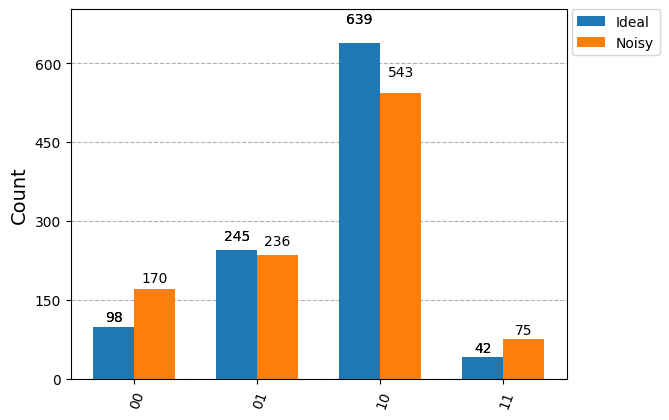

In [27]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [28]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [29]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9833487375393272

In [30]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [31]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
# from arbitrary_angle_spillover_env import (
#     ArbitraryAngleSpilloverEnv,
# )
# from gate_level.spillover_noise_use_case.generic_spillover.local_spillover_env import (
#     LocalSpilloverEnvironment,
# )

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}

action_space = Box(low=-0.5, high=0.5, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[3,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)
# q_env = LocalSpilloverEnvironment(
#     q_env_config,
#     circuit_context=circuit.assign_parameters(param_dict),  # Pass the circuit already transpiled through custom pass
# )
# q_env = ArbitraryAngleSpilloverEnv(
#     q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
# )

In [32]:
from typing import Optional, Dict, Any, SupportsFloat
from rl_qoc.environment.context_aware_quantum_environment import ObsType, ActType

class OneParamAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params,
        discrete_history_length,
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-np.pi] * 1),
            high=np.array([np.pi] * 1),
            dtype=np.float64,
        )

        self.discrete_reward_history = np.ones((discrete_history_length, self.num_params))
        self.discrete_obs_vals = np.linspace(
            self.observation_space.low, self.observation_space.high, self.num_params
        ).flatten()
        print(f"Observation Vals: {self.discrete_obs_vals}")
        self.obs_angles = np.zeros(self.observation_space.shape)

    def define_target_and_circuits(self):
        """
        Define the target gate and the circuits to be executed
        """
        circuit_context = causal_cone_circuit(
            self.circuit_context, list(self.config.env_metadata["target_subsystem"])
        )[0]
        self._physical_target_qubits = list(range(circuit_context.num_qubits))
        self._circuit_context = circuit_context
        target, custom_circuits, baseline_circuits = (
            super().define_target_and_circuits()
        )

        return target, custom_circuits, baseline_circuits

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        :param seed: Seed for the environment
        :param options: Options for the environment
        :return: Initial observation and info
        """

        # Reset the environment
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
        else:
            self.obs_angles = self._get_new_angles()

        phi = np.zeros(self.unbound_circuit_context.num_qubits)
        phi[2] = self.obs_angles[0]
        # phi[3] = self.obs_angles[0]

        param_dict = {self.circuit_parameters[i].name: phi[i] for i in range(len(phi))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        # Generate the initial observation
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", phi)
        print(f"Environment Observation: {env_obs}")
        # Return the initial observation and info
        return env_obs, {}
    
    def _get_new_angles(self):
        if self.circuit_param_distribution == "uniform":
            angles = np.random.uniform(
                self.observation_space.low, self.observation_space.high, self.observation_space.shape
            )
        if self.circuit_param_distribution == "simple_discrete":
            self.prob_weights = np.ones_like(self.discrete_obs_vals)
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                p=self.prob_weights,
                replace=True
            )
        if self.circuit_param_distribution == "moving_discrete":
            self.prob_weights = (np.mean(
                self.discrete_reward_history, axis=0
            ) + np.log10(self.optimal_error_precision)) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                replace=True,
                p=self.prob_weights
            )
        return angles
    
    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        print(f"batch action shape: {action.shape}")
        
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info
    
    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals - obs * np.pi))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )
    
    # def initialize_discrete_history(self):
    #     # Initializes Discrete History with success of zeros policy
    #     for set_obs in np.tile(self.discrete_obs_vals, (self.discrete_history_length,)):
    #         _obs, info = self.reset(debug_obs=np.array([set_obs]))
    #         obs, reward, terminated, truncated, info = self.step(np.zeros((self.batch_size,) + self.action_space.shape))
    
    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        :return: Observation
        """
        return self.obs_angles / np.pi # Normalized to multiples of pi

    def _get_info(self) -> Any:
        return {}

In [33]:
# Testing angle handling

import numpy as np

qubits_with_obs = np.array([1, 2, 4], dtype=np.int8)

obs_arr = np.zeros(6)
obs_arr[qubits_with_obs] = np.ones(3)

print(obs_arr)

[0. 1. 1. 0. 1. 0.]


In [34]:
from typing import Optional, Dict, Any, SupportsFloat
from rl_qoc.environment.context_aware_quantum_environment import ObsType, ActType

class MultiParamAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params,
        discrete_history_length,
        qubits_with_obs,
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
    ):
        """
        Initialize the environment
        """
        self.qubits_with_obs = qubits_with_obs
        self.num_obs = len(qubits_with_obs)
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-np.pi] * self.num_obs),
            high=np.array([np.pi] * self.num_obs),
            dtype=np.float64,
        )

        self.discrete_reward_history = np.ones((discrete_history_length, self.num_params))
        self.discrete_obs_vals = np.linspace(
            self.observation_space.low, self.observation_space.high, self.num_params
        ).flatten()
        print(f"Observation Vals: {self.discrete_obs_vals}")
        self.obs_angles = np.zeros(self.observation_space.shape)

    def define_target_and_circuits(self):
        """
        Define the target gate and the circuits to be executed
        """
        circuit_context = causal_cone_circuit(
            self.circuit_context, list(self.config.env_metadata["target_subsystem"])
        )[0]
        self._physical_target_qubits = list(range(circuit_context.num_qubits))
        self._circuit_context = circuit_context
        target, custom_circuits, baseline_circuits = (
            super().define_target_and_circuits()
        )

        return target, custom_circuits, baseline_circuits

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        :param seed: Seed for the environment
        :param options: Options for the environment
        :return: Initial observation and info
        """

        # Reset the environment
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
        else:
            self.obs_angles = self._get_new_angles()

        phi = np.zeros(self.unbound_circuit_context.num_qubits)
        phi[self.qubits_with_obs] = self.obs_angles

        param_dict = {self.circuit_parameters[i].name: phi[i] for i in range(len(phi))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        # Generate the initial observation
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", phi)
        print(f"Environment Observation: {env_obs}")
        # Return the initial observation and info
        return env_obs, {}
    
    def _get_new_angles(self):
        if self.circuit_param_distribution == "uniform":
            angles = np.random.uniform(
                self.observation_space.low, self.observation_space.high, self.observation_space.shape
            )
        if self.circuit_param_distribution == "simple_discrete":
            self.prob_weights = np.ones_like(self.discrete_obs_vals)
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                p=self.prob_weights,
                replace=True
            )
        if self.circuit_param_distribution == "moving_discrete":
            self.prob_weights = (np.mean(
                self.discrete_reward_history, axis=0
            ) + np.log10(self.optimal_error_precision)) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                replace=True,
                p=self.prob_weights
            )
        return angles
    
    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        print(f"batch action shape: {action.shape}")
        
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        if self.circuit_param_distribution != "uniform":
            self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info
    
    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals - obs * np.pi))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )
    
    # def initialize_discrete_history(self):
    #     # Initializes Discrete History with success of zeros policy
    #     for set_obs in np.tile(self.discrete_obs_vals, (self.discrete_history_length,)):
    #         _obs, info = self.reset(debug_obs=np.array([set_obs]))
    #         obs, reward, terminated, truncated, info = self.step(np.zeros((self.batch_size,) + self.action_space.shape))
    
    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        :return: Observation
        """
        return self.obs_angles / np.pi # Normalized to multiples of pi

    def _get_info(self) -> Any:
        return {}

In [40]:
one_q_env = MultiParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    qubits_with_obs=np.array([2], dtype=np.int8),
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [41]:
rescaled_q_env = RescaleAndClipAction(one_q_env, min_action=-1., max_action=1.)

In [42]:
rescaled_q_env.action_space

Box(-0.5, 0.5, (7,), float32)

In [43]:
rescaled_q_env.observation_space

Box(-3.141592653589793, 3.141592653589793, (1,), float64)

In [44]:
# Testing n-reps fitting

from typing import Callable, Any, Optional, List, Literal
from scipy.optimize import curve_fit

def _fit_function(n, eps_quad):
    return 3/5 + 2/5 * np.cos(n * eps_quad)

def _fit_function_2(n, delta_1, delta_2):
    return (4 * np.cos(n * delta_1)**2 * np.cos(n * delta_2)**2 + 1) / 5

def _inverse_fit_function(reward, n, spam, eps_lin, eps_quad):
    return reward + eps_lin * (n - 1) + eps_quad * (n**2 - 1)

def custom_reward_fit(
    env,
    params: np.array,
    execution_config: Optional[ExecutionConfig] = None,
    fit_function: Optional[Callable] = None,
    inverse_fit_function: Optional[Callable] = None,
    update_fit_params: bool = True,
    reward_method: Optional[
        Literal["cafe", "channel", "orbit", "state", "xeb", "fidelity"]
    ] = None,
) -> plt.Figure:
    """
    Method to fit the initial reward function to the first set of actions in the environment
    with respect to the number of repetitions of the cycle circuit
    """

    initial_execution_config = env.config.execution_config
    initial_reward_method = env.config.reward_method
    if execution_config is not None:
        env.config.execution_config = execution_config
    if reward_method is not None:
        env.config.reward_method = reward_method
    reward_data = []
    for i in range(len(env.config.execution_config.n_reps)):
        env.config.execution_config.n_reps_index = i
        reward = env.perform_action(params, update_env_history=False)
        reward_data.append(np.mean(reward))
    if fit_function is None or inverse_fit_function is None:
        fit_function = _fit_function
        inverse_fit_function = _inverse_fit_function

    p0 = [0.078,]  # Initial guess for the parameters
    lower_bounds = [0.0,]
    upper_bounds = [10.,]

    popt, pcov = curve_fit(
        fit_function,
        env.config.execution_config.n_reps,
        reward_data,
        p0=p0,
        bounds=(lower_bounds, upper_bounds),
    )

    # Create a figure and return it to the user
    fig, ax = plt.subplots()
    ax.plot(
        env.config.execution_config.n_reps, reward_data, label="Data", marker="o"
    )
    ax.plot(
        env.config.execution_config.n_reps,
        [fit_function(n, *popt) for n in env.config.execution_config.n_reps],
        label="Fit",
    )
    ax.set_xlabel("Number of repetitions")
    ax.set_ylabel("Reward")
    ax.legend()
    ax.set_title("Initial reward fit (for varying number of repetitions)")
    # Print found parameters
    print("Found parameters:", popt)

    if execution_config is not None:
        env.config.execution_config = initial_execution_config
    if reward_method is not None:
        env.config.reward_method = initial_reward_method
    if update_fit_params:
        env._fit_function = lambda reward, n: inverse_fit_function(
            reward, n, *popt
        )
        env._fit_params = popt
    return fig, reward_data

In [45]:
_obs, info = one_q_env.reset(debug_obs=np.array([np.pi]))

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]


In [46]:
print(one_q_env.obs_angles)

[3.14159265]


Sampled angles:  [0.  0.  1.5 0.  0.  0. ]
Environment Observation: [0.47746483]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9998451496771608 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9990720799554186 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9975218482515713 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9954097878483795 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9932325582126722 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9899616262227603 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Ga

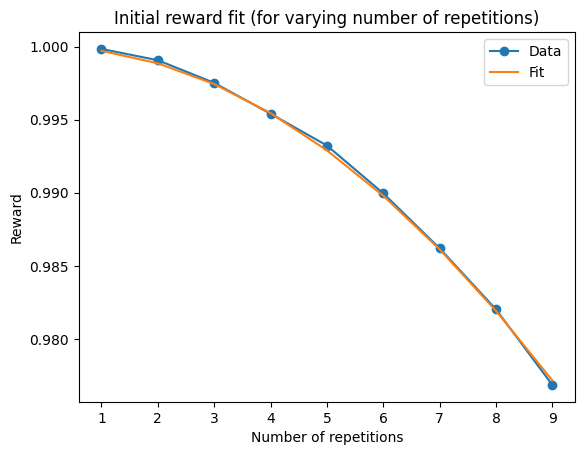

In [47]:
_obs, info = one_q_env.reset(debug_obs=np.array([1.5]))

fig, reward_data = custom_reward_fit(  
    one_q_env,
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 10),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method=None,
)

In [335]:
env = one_q_env
params = np.zeros((1, 7))
execution_config = ExecutionConfig(
    sampling_paulis=1000,
    n_shots=100,
    n_reps=list(
        range(1, 10),
    ),
    dfe_precision=None,
    seed=q_env_config.seed,
    control_flow_enabled=False,
)
update_fit_params=False
reward_method=None
fit_function=None
inverse_fit_function=None

Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 1.0001031420420232 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 0.999949217083364 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 1.0000574139486242 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 0.999898596136835 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 1.000220417584804 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 0.999945690029351 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 0.9999979722258336 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 0.99981299620888

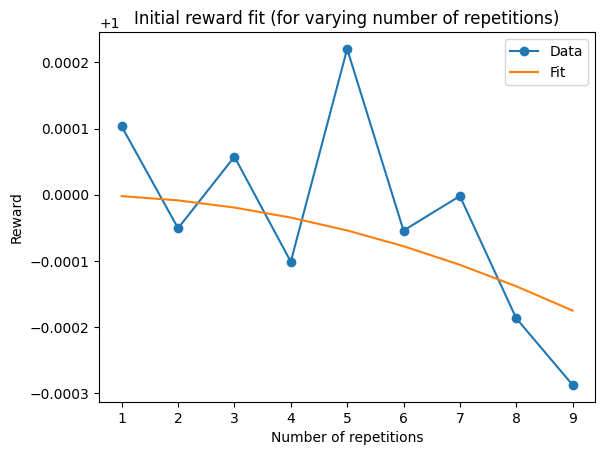

In [334]:
# Expanding everything

initial_execution_config = env.config.execution_config
initial_reward_method = env.config.reward_method
if execution_config is not None:
    env.config.execution_config = execution_config
if reward_method is not None:
    env.config.reward_method = reward_method
reward_data = []



for i in range(len(env.config.execution_config.n_reps)):
    env.config.execution_config.n_reps_index = i
    reward = env.perform_action(params, update_env_history=False)
    reward_data.append(np.mean(reward))
if fit_function is None or inverse_fit_function is None:
    fit_function = _fit_function
    inverse_fit_function = _inverse_fit_function

p0 = [0.078,]  # Initial guess for the parameters
lower_bounds = [0.0,]
upper_bounds = [10.,]

popt, pcov = curve_fit(
    fit_function,
    env.config.execution_config.n_reps,
    reward_data,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
)

# Create a figure and return it to the user
fig, ax = plt.subplots()
ax.plot(
    env.config.execution_config.n_reps, reward_data, label="Data", marker="o"
)
ax.plot(
    env.config.execution_config.n_reps,
    [fit_function(n, *popt) for n in env.config.execution_config.n_reps],
    label="Fit",
)
ax.set_xlabel("Number of repetitions")
ax.set_ylabel("Reward")
ax.legend()
ax.set_title("Initial reward fit (for varying number of repetitions)")
# Print found parameters
print("Found parameters:", popt)

if execution_config is not None:
    env.config.execution_config = initial_execution_config
if reward_method is not None:
    env.config.reward_method = initial_reward_method
if update_fit_params:
    env._fit_function = lambda reward, n: inverse_fit_function(
        reward, n, *popt
    )
    env._fit_params = popt

In [336]:
baseline_reward = []

alt_q_env.clear_history()
for set_obs in alt_q_env.discrete_obs_vals:
    # _obs, info = alt_q_env.reset(debug_obs=np.array([1.]))
    _obs, info = alt_q_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((alt_q_env.batch_size,) + alt_q_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = alt_q_env.step(zero_action)
    baseline_reward.append(np.mean(reward))
    print(f"discrete reward history: {alt_q_env.discrete_reward_history}")

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9987669334932512
Reward (avg): 0.993175625507106 Std: 0.014323222268462093
obs: [-1.]
reward: [6.         1.70516172 2.25605242 2.66079933 2.14014362 1.98047514
 1.59467745 6.         1.98960437 2.38513927 6.         1.84669618
 6.         1.69525929 6.         6.         6.         1.53112081
 1.71234477 1.83734795 6.         2.28245587 2.07941596 6.
 1.53464772 2.15919127 1.70953218 1.54274085 1.85634402 2.20066406
 6.         1.61135212]
discrete reward history: [[3.19722395 1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.   

In [67]:
baseline_reward = []

one_q_env.clear_history()
for set_obs in one_q_env.discrete_obs_vals:
    # _obs, info = alt_q_env.reset(debug_obs=np.array([1.]))
    _obs, info = one_q_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((one_q_env.batch_size,) + one_q_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = one_q_env.step(zero_action)
    baseline_reward.append(np.mean(reward))
    print(f"discrete reward history: {one_q_env.discrete_reward_history}")

Sampled angles:  [ 0.          0.          0.         -3.14159265  0.          0.        ]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9157536747913018
Reward (avg): 0.6648759144718193 Std: 0.016645254604498737
obs: [-1.]
reward: [0.49444177 0.47944834 0.51606315 0.44935761 0.43390988 0.48046687
 0.45570487 0.47904792 0.48831312 0.47005733 0.46222032 0.47028967
 0.48413372 0.46115531 0.49004137 0.44650495 0.51646135 0.48711611
 0.46749094 0.46910915 0.51211838 0.43229883 0.48809231 0.45770462
 0.50667719 0.48261513 0.46893297 0.47269017 0.45604077 0.50713822
 0.46281756 0.46216867]
discrete reward history: [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Sampled angles:  [ 0.          0.          0.         -2.74889357  0.          0.        ]
Environment Observation: [

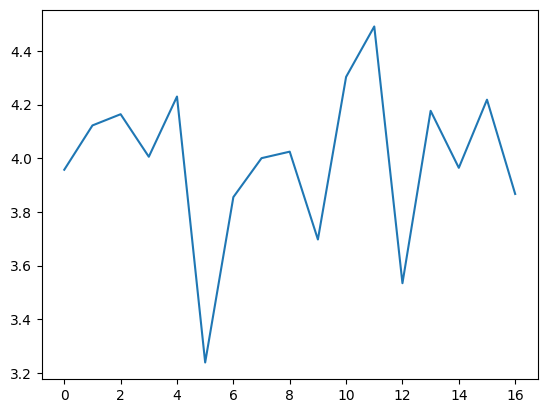

In [339]:
plt.plot(baseline_reward)

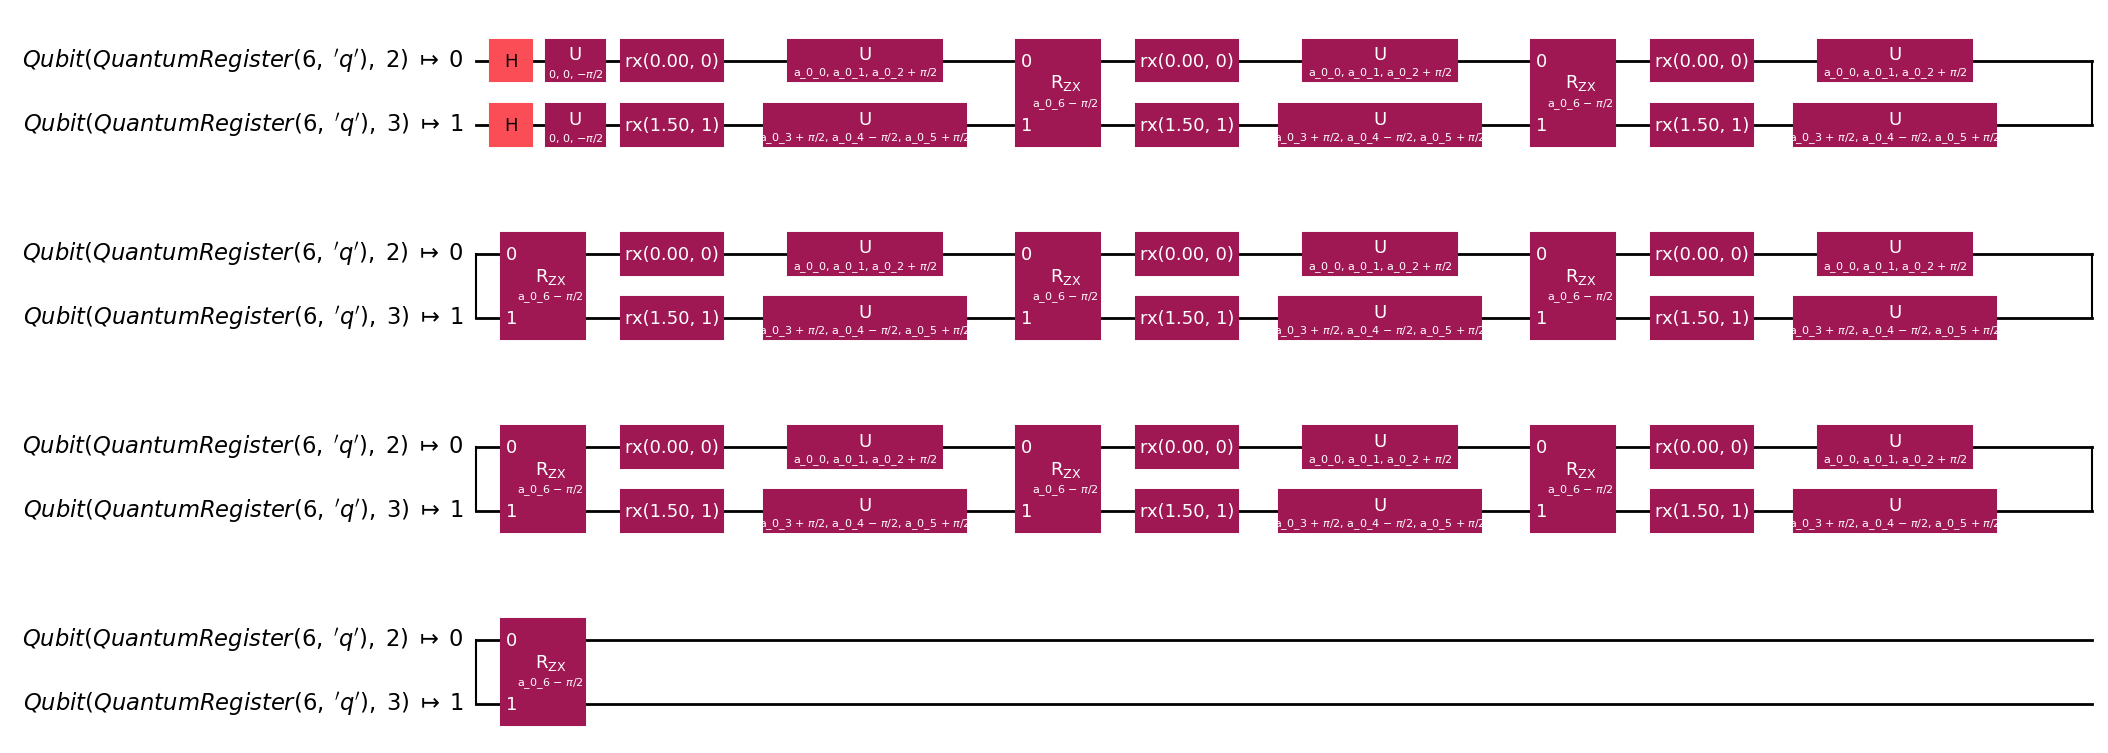

In [366]:
# nOT one

pub_obj = one_q_env.pubs[-1]

pub_obj.circuit.draw("mpl")

In [367]:
for circ in pub_obj.circuit:
    if circ.operation.name == "unitary":
        print(circ)
        print(circ.params)

CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=())
[array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])]
CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[0.73168887+0.j        , 0.        -0.68163876j],
       [0.        -0.68163876j, 0.73168887+0.j        ]])]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=())
[array([[0.73168887+0.j        , 0.        -0.68163876j],
       [0.        -0.68163876j, 0.73168887+0.j        ]])]
CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=())
[array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])]
CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[0.7

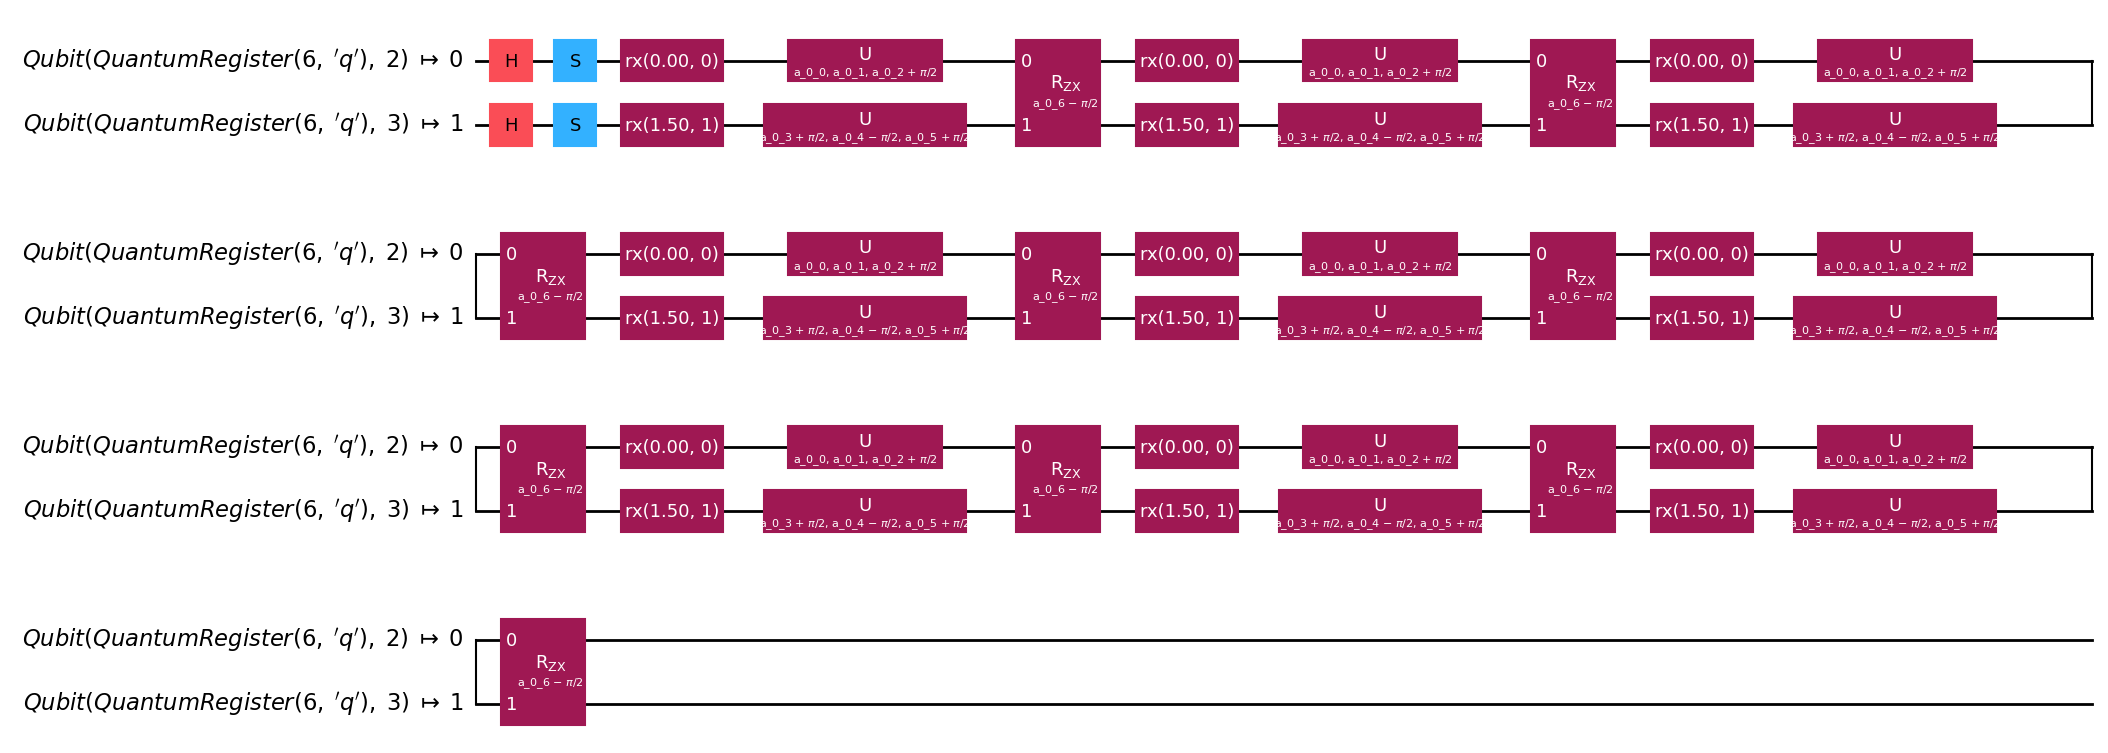

In [302]:
# Correct one

one_q_env.pubs[-1].circuit.draw("mpl")

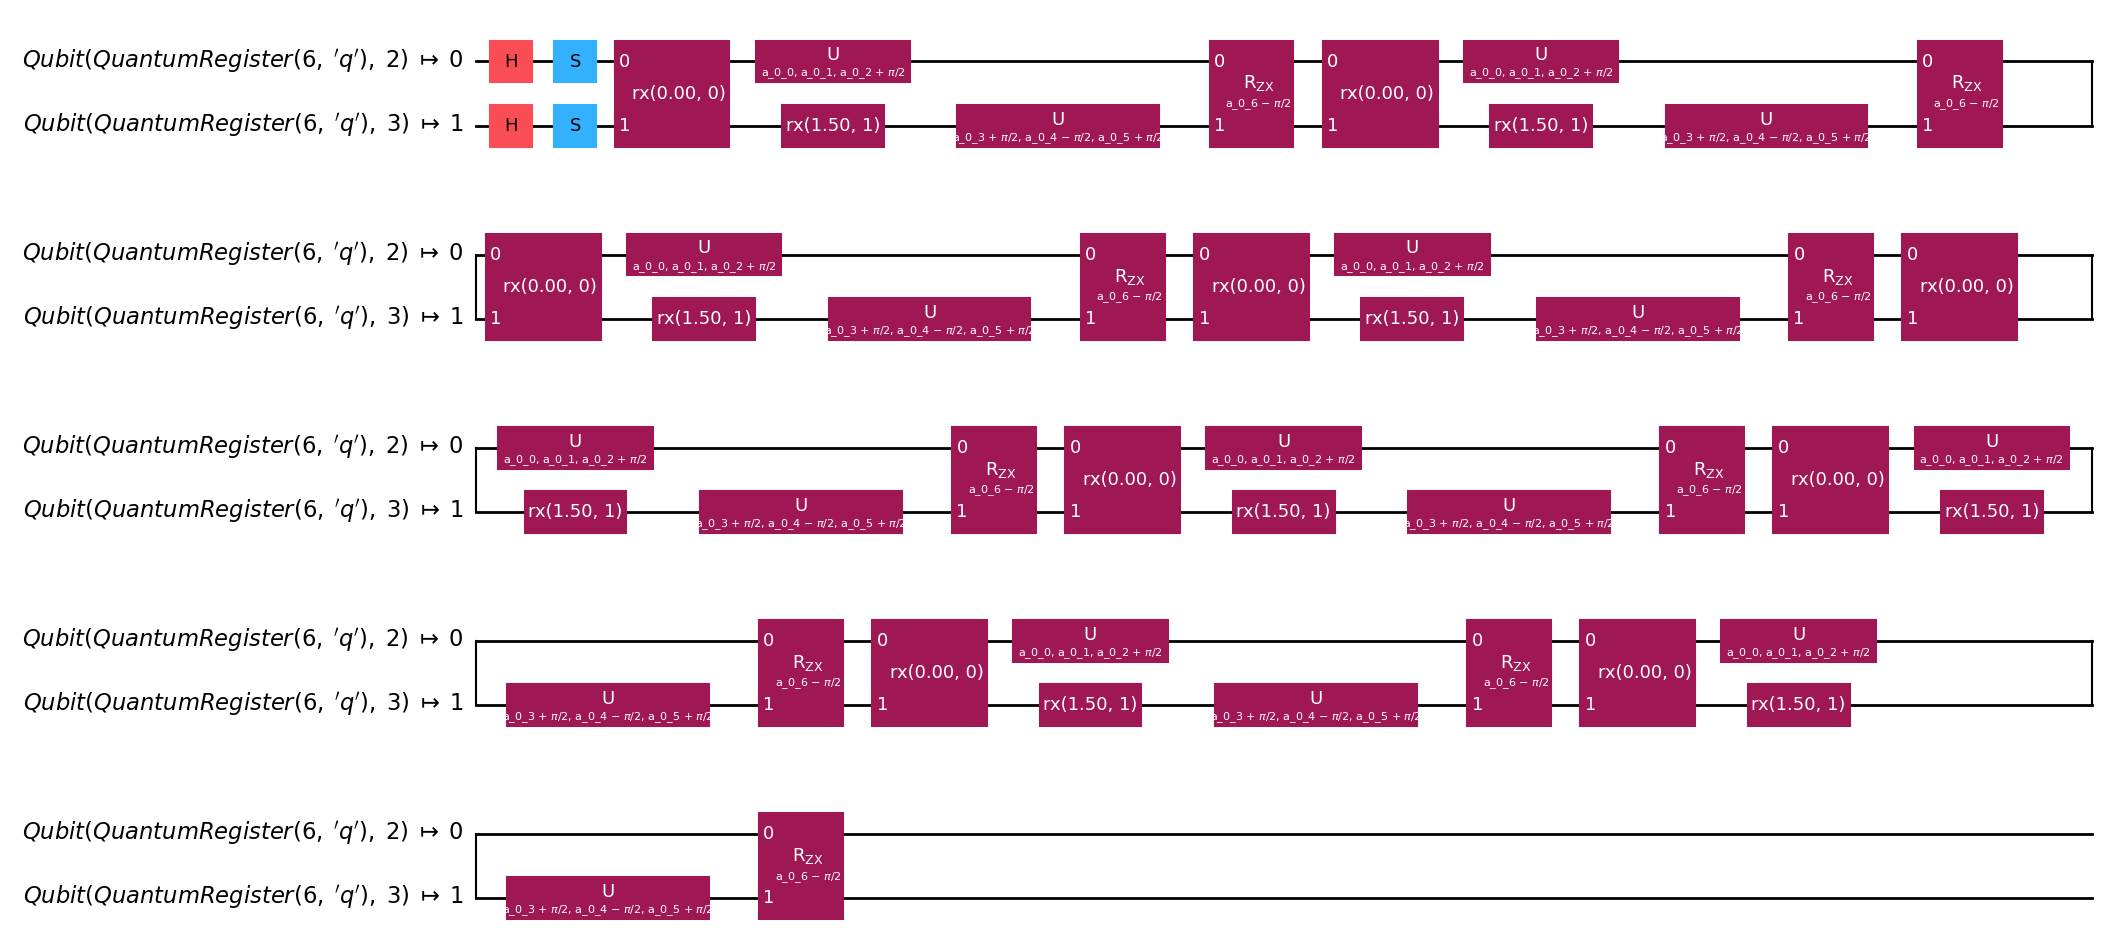

In [273]:
# Incorrect One

one_q_env.pubs[-1].circuit.draw("mpl")

In [332]:
# Testing default env

from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

q_env = ArbitraryAngleSpilloverEnv(
    q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Sampled angles:  [3.33963104 5.58711255 3.74894089 1.44824163 2.33898309 4.5937506 ]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 1.0000334991215085 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 1.0000711371783833 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 1.000017753459085 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 0.9999217411773247 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 0.9997759482454993 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 0.9999642507981022 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0
Reward (avg): 1.000148718956778 Std: 0.0
Starting simulation benchmar

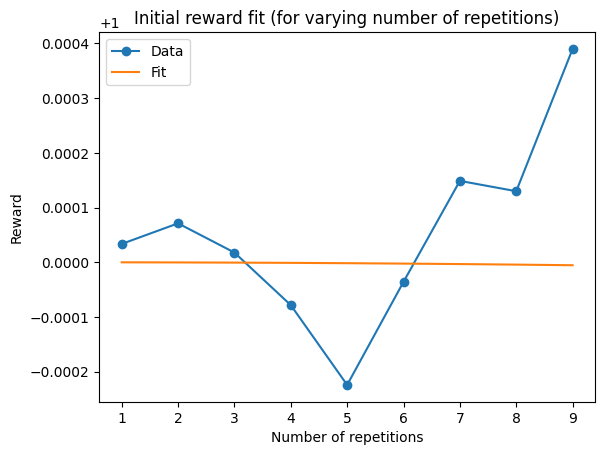

In [333]:
_obs, info = q_env.reset()

fig, reward_data = custom_reward_fit(  
    q_env,
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 10),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method=None,
)

In [128]:
print(one_q_env._get_obs())

[0.47746483]


In [34]:
alt_q_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


Sampled angles:  [0.  0.  1.5 0.  0.  0. ]
Environment Observation: [0.47746483]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.999829061643806 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9975522598199241 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.996004018432361 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9928960412094687 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9997187829574395
Reward (avg): 0.9831190112594232 Std: 0.0
Found parameters: [0.03090487]


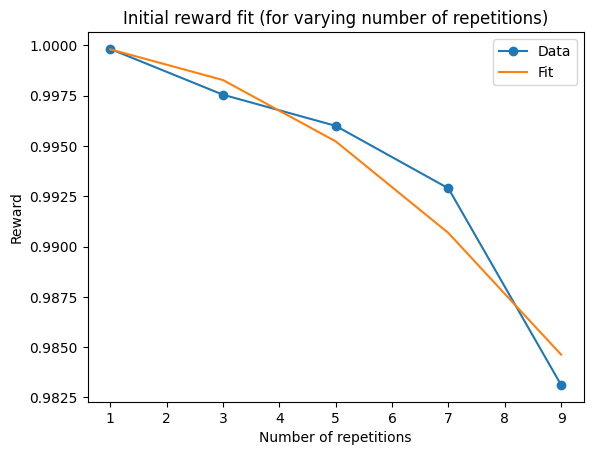

In [35]:
_obs, info = alt_q_env.reset(debug_obs=np.array([1.5]))

fig, reward_data = custom_reward_fit(  
    alt_q_env,
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 10, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method=None,
)